In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from util import get_dummies, detect_str_columns,model,profit_linechart,profit_linechart_all,logistic_model
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# ----設定繪圖-------
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

# -------------- modeling - Random Forest--------------------
# 讀取資料
data = pd.read_csv('contract.csv' ,encoding = 'cp950')

# 偵測有字串的欄位
str_columns = detect_str_columns(data)
dataset = get_dummies(str_columns, data)

# 切分資料集
X =dataset.drop(columns=['buy'])
y =dataset['buy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 

# ------------ 資料處理與轉換 - 將UID拿出來 ------------
# 保留UID
train_uid = X_train['UID']
test_uid = X_test['UID']

# 設定xgb 分類模型
del X_train['UID']
del X_test['UID']


# -------------XGBClassifier重要性分析-------------
# 命名模型物件
xgb_model = XGBClassifier(n_estimators=100 ,random_state = 0, nthread = 8, learning_rate=0.5)

# 進行訓練
model_xgb = xgb_model.fit(X_train, y_train, verbose=True,
                          eval_set=[(X_train, y_train), (X_test, y_test)])

# 抓出重要特徵值的重要性
feat_imp = model_xgb.feature_importances_
feat_imp.sum()

# 抓出特徵值欄位
feat = X_train.columns.tolist()
# 合併變成DataFrame
res_data = pd.DataFrame({'Features': feat, 'Importance': feat_imp})

[0]	validation_0-error:0.16075	validation_1-error:0.1575
[1]	validation_0-error:0.146875	validation_1-error:0.1375
[2]	validation_0-error:0.1445	validation_1-error:0.1335
[3]	validation_0-error:0.13975	validation_1-error:0.133
[4]	validation_0-error:0.137625	validation_1-error:0.132
[5]	validation_0-error:0.1385	validation_1-error:0.134
[6]	validation_0-error:0.137875	validation_1-error:0.134
[7]	validation_0-error:0.136875	validation_1-error:0.136
[8]	validation_0-error:0.13625	validation_1-error:0.1365
[9]	validation_0-error:0.135875	validation_1-error:0.137
[10]	validation_0-error:0.134875	validation_1-error:0.132
[11]	validation_0-error:0.134125	validation_1-error:0.13
[12]	validation_0-error:0.133125	validation_1-error:0.1345
[13]	validation_0-error:0.131	validation_1-error:0.134
[14]	validation_0-error:0.13125	validation_1-error:0.1335
[15]	validation_0-error:0.130625	validation_1-error:0.134
[16]	validation_0-error:0.13075	validation_1-error:0.1325
[17]	validation_0-error:0.1315

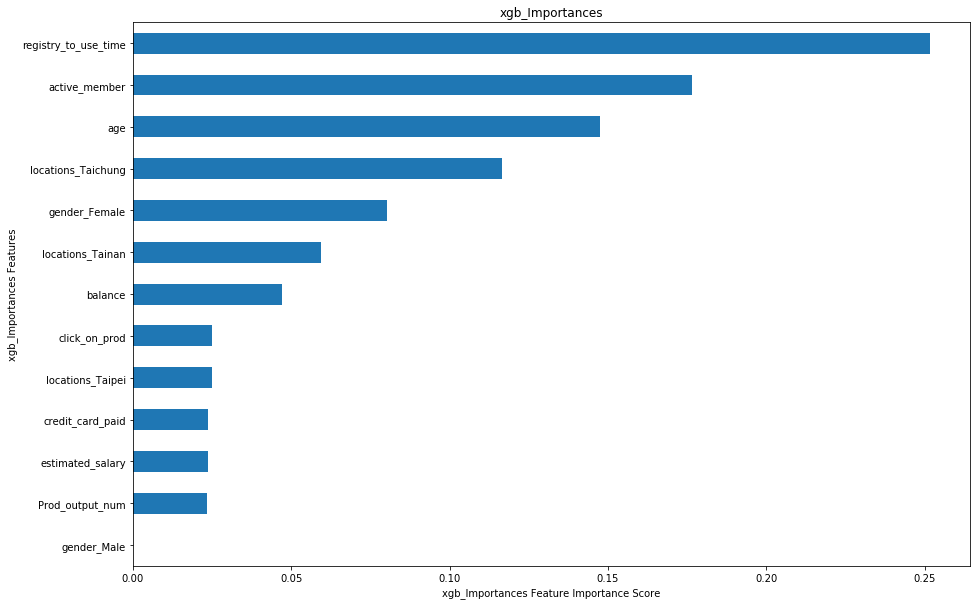

In [2]:
# 根據Importance，由高到低排序
res_data = res_data.sort_values(by='Importance', ascending=False)

# 視覺化重要性
res_data = res_data.sort_values(by='Importance', ascending=True)

plot_name = 'xgb_Importances'
res_data.plot('Features', 'Importance', kind='barh', 
              title=plot_name, figsize = (15,10),legend=None)
plt.xlabel(plot_name+' Feature Importance Score')
plt.ylabel(plot_name+' Features')
plt.savefig(plot_name+'.png', dpi=300)
plt.show()

C:\Users\POPO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


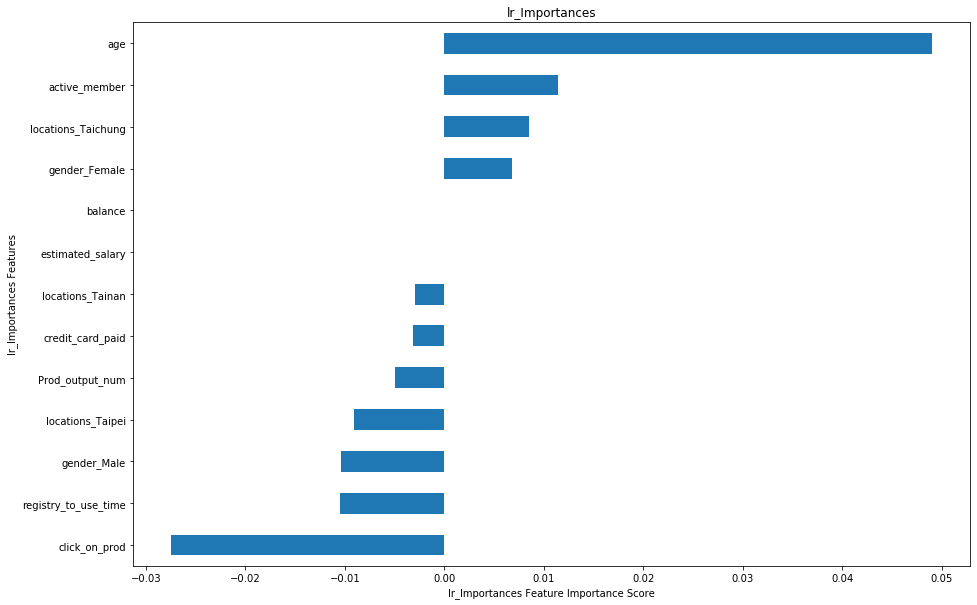

In [3]:
# -------------- 羅吉斯迴歸 -------------------
# 命名模型物件
from sklearn.linear_model import LogisticRegression
logistic_reg =LogisticRegression()
# 進行訓練
logistic_reg.fit(X_train, y_train)
logistic_reg.coef_
X_train.columns

# 抓出重要特徵值的重要性
feat_imp = logistic_reg.coef_.tolist()[0]

# 抓出特徵值欄位
feat = X_train.columns.tolist()

# 合併變成DataFrame
res_data = pd.DataFrame({'Features': feat, 'Importance': feat_imp})

# 特徵值的正/負屬性高到低
res_data = res_data.sort_values(by='Importance', ascending=True)

# 知道單位增/減量
res_data['delta'] = np.exp(res_data['Importance'])-1

# 視覺化重要性
plot_name = 'lr_Importances'
res_data.plot('Features', 'delta', kind='barh', 
              title=plot_name, figsize = (15,10),legend=None)
plt.xlabel(plot_name+' Feature Importance Score')
plt.ylabel(plot_name+' Features')
plt.savefig(plot_name+'.png', dpi=300)
plt.show()
res_data.to_csv(plot_name+'.csv' ,encoding = 'cp950')

In [4]:
from sklearn.tree import DecisionTreeClassifier
# 命名模型物件
decision_reg = DecisionTreeClassifier( max_leaf_nodes = 7,  max_depth= 5,criterion = 'entropy')

# 進行訓練
decision_reg.fit(X_train, y_train)


# 畫決策樹的圖
from sklearn import tree
import graphviz 
import os
import platform

if platform.system() ==  'Windows':
    os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
    
dot_data = tree.export_graphviz(decision_reg, out_file=None, 
                     feature_names=X_test.columns,  
                     class_names=['no','yes'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render('marketing')

'marketing.pdf'